In [2]:
%load_ext autoreload
%autoreload 2

In [92]:
import lightgbm as lgbm
import optuna
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import uniform
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from helper import *
from make_features import *
loc_data = '/Users/yuxuan/Desktop/kaggle_optiver/optiver-realized-volatility-prediction'

In [4]:
def RMSPE_objective(y_true, y_pred):
    raise NotImplementedError()
    return grad, hess

def RMSPE(y_true, y_pred):
    digits = 5
    err = (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))
    return 'RMSPE', np.round(err, digits), False

def R2(y_true, y_pred):
    digits = 5
    return 'R2', np.round(r2_score(y_true, y_pred),digits), True

In [14]:
df_all = pd.read_csv(f'{loc_data}/workingdata.csv', index_col = 0)

In [16]:
index_toy = df_all.stock_id <= 20
df_toy = df_all[index_toy]

In [17]:
df_toy.shape

(76599, 215)

In [18]:
X = df_toy.drop(columns = ['stock_id', 'time_id', 'target'])
y = df_toy.target

In [24]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, 
                                                    random_state = 101)
eval_set = [(X_eval, y_eval)] 

In [56]:
def run_lgbm(X_train, y_train, eval_set, **lgbm_args):
    # supress eval output
    reg = lgbm.LGBMRegressor(**lgbm_args)
    reg.fit(X_train, y_train,
            eval_set = eval_set,
            eval_metric = ['l2', R2, RMSPE],
            callbacks = [lgbm.log_evaluation(period=0)]
           )
    
    fig, ax = plt.subplots(1, 3, figsize = (10, 4))
    for i,name in enumerate(['l2', 'R2', 'RMSPE']):
        lgbm.plot_metric(reg, ax = ax[i], metric = name, title = name)
    fig.tight_layout()
    
    print('best score')
    print(reg.best_score_['valid_0'])
    return reg

In [76]:
8000 / (76599 * 0.8)

0.1305500071802504

In [86]:
def make_param_grid(trial):
        param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [2000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 1020, step=40),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 8000, step=100),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.9, step=0.1
        ),
        }
        
        return param_grid

In [87]:
def objective(trial, X, y, metric = 'RMSPE'):
    param_grid = make_param_grid(trial)
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, 
                                                    random_state = 101)
    eval_set = [(X_eval, y_eval)] 

    model = lgbm.LGBMRegressor(**param_grid)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_eval, y_eval)],
        eval_names = 'validation',
        eval_metric= RMSPE,
        callbacks = [lgbm.log_evaluation(period=0)]
    )

    return model.evals_result_['validation'][metric][-1]

In [88]:
with timer('optuna'):
    study = optuna.create_study(direction="minimize", study_name="LGBM")
    func = lambda trial: objective(trial, X, y)
    study.optimize(func, n_trials=10)

[I 2022-07-19 11:09:37,517] A new study created in memory with name: LGBM
[I 2022-07-19 11:09:55,469] Trial 0 finished with value: 2.77433 and parameters: {'n_estimators': 2000, 'learning_rate': 0.10768368831554392, 'num_leaves': 820, 'max_depth': 7, 'min_data_in_leaf': 6300, 'min_gain_to_split': 14.254427528626843, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 2.77433.
[I 2022-07-19 11:10:10,254] Trial 1 finished with value: 2.77433 and parameters: {'n_estimators': 2000, 'learning_rate': 0.29951546671062473, 'num_leaves': 420, 'max_depth': 3, 'min_data_in_leaf': 400, 'min_gain_to_split': 11.513273068937915, 'feature_fraction': 0.5}. Best is trial 0 with value: 2.77433.
[I 2022-07-19 11:10:25,311] Trial 2 finished with value: 2.77433 and parameters: {'n_estimators': 2000, 'learning_rate': 0.08434013489974858, 'num_leaves': 900, 'max_depth': 5, 'min_data_in_leaf': 1600, 'min_gain_to_split': 3.5900357428881002, 'feature_fraction': 0.5}. Best is trial 0 with value: 

[optuna]  194.864sec


best score
OrderedDict([('l2', 1.8827346741461822e-06), ('R2', 0.8249), ('RMSPE', 0.27123)])
[lgbm run]  4.935sec


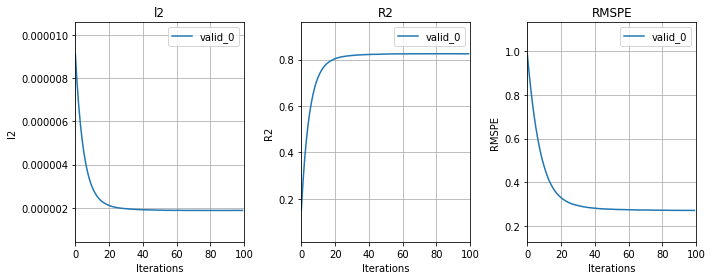

In [58]:
# default
with timer('lgbm run'):
    m = run_lgbm(X_train, y_train, eval_set, 
             n_estimators = 100,
             learning_rate = 0.1,
             random_state = 101
            )

best score
OrderedDict([('l2', 1.8539393060949814e-06), ('R2', 0.82758), ('RMSPE', 0.26808)])
[lgbm run]  50.053sec


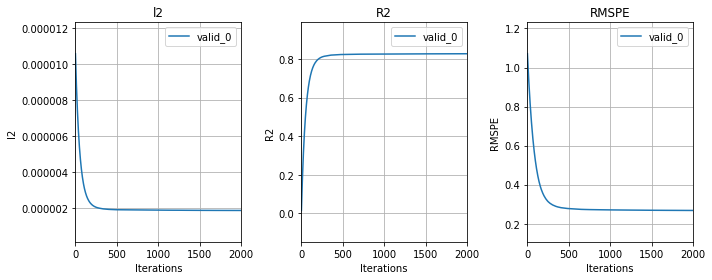

In [61]:
with timer('lgbm run'):
    m = run_lgbm(X_train, y_train, eval_set, 
             n_estimators = 2000,
             learning_rate = 0.01,
             random_state = 101
            )

best score
OrderedDict([('l2', 1.8858853940652814e-06), ('R2', 0.82461), ('RMSPE', 0.26805)])
[lgbm run]  46.879sec


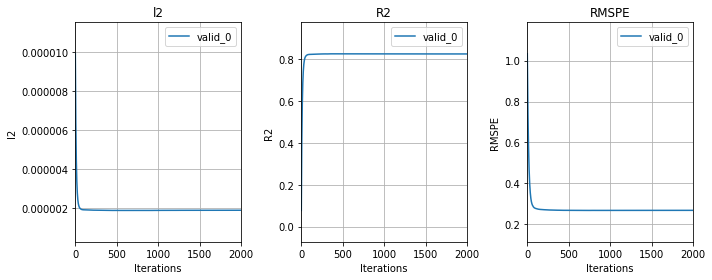

In [62]:
with timer('lgbm run'):
    m = run_lgbm(X_train, y_train, eval_set, 
             n_estimators = 2000,
             learning_rate = 0.05,
             random_state = 101
            )

best score
OrderedDict([('l2', 1.8513091286916452e-06), ('R2', 0.82782), ('RMSPE', 0.26628)])
[lgbm run]  114.604sec


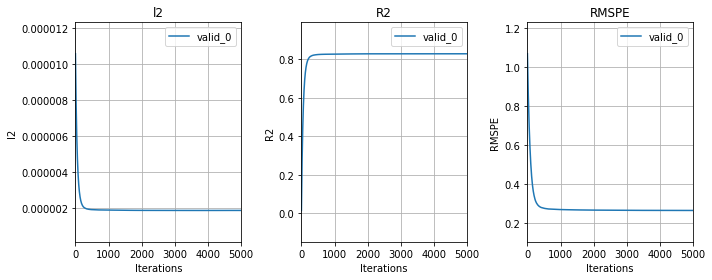

In [63]:
with timer('lgbm run'):
    m = run_lgbm(X_train, y_train, eval_set, 
             n_estimators = 5000,
             learning_rate = 0.01,
             random_state = 101
            )

best score
OrderedDict([('l2', 1.8544775760315884e-06), ('R2', 0.82753), ('RMSPE', 0.26919)])
[lgbm run]  41.979sec


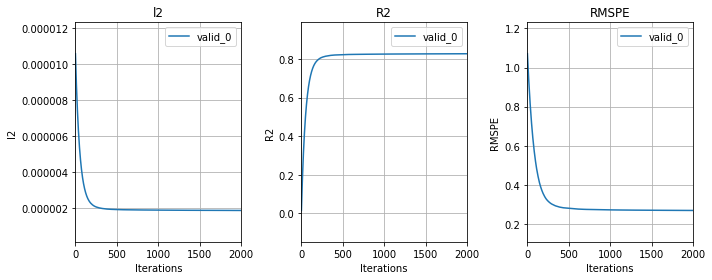

In [64]:
with timer('lgbm run'):
    m = run_lgbm(X_train, y_train, eval_set, 
                 n_estimators = 2000,
                 learning_rate = 0.01,
                 random_state = 101,
                 max_depth = 7,
                 num_leaves = 20
                )

best score
OrderedDict([('l2', 1.8561866401158658e-06), ('R2', 0.82737), ('RMSPE', 0.26798)])
[lgbm run]  41.989sec


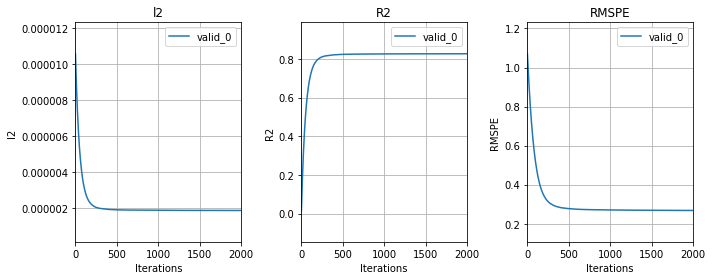

In [65]:
with timer('lgbm run'):
    m = run_lgbm(X_train, y_train, eval_set, 
                 n_estimators = 2000,
                 learning_rate = 0.01,
                 random_state = 101,
                 feature_fraction = 0.8
                )

In [66]:
m

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.8, importance_type='split', learning_rate=0.01,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=2000, n_jobs=-1, num_leaves=31,
              objective=None, random_state=101, reg_alpha=0.0, reg_lambda=0.0,
              silent='warn', subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [73]:
m.evals_result_['valid_0']['RMSPE'][-10:]

[0.26797,
 0.26797,
 0.26797,
 0.26797,
 0.26797,
 0.26797,
 0.26797,
 0.26797,
 0.26797,
 0.26798]

In [108]:
# distributions = {'learning_rate' : uniform(loc = 0.01, scale = 0.19),
#                  'feature_fraction' : uniform(loc = 0.3, scale = 0.8),
#                  'max_depth' : np.arange(3, 11),
#                  'min_data_in_leaf' : np.arange(3000, 21000, 1000),
#                 }

distributions = {'learning_rate' : uniform(loc = 0.01, scale = 0.19),
                 'colsample_bytree' : uniform(loc = 0.3, scale = 0.6),
                 'max_depth' : np.arange(6, 11),
                 'min_child_samples' : np.arange(500, 5500, 500),
                 'num_leaves' : np.arange(100, 900, 100),
                }

In [109]:
reg = lgbm.LGBMRegressor(n_estimators = 2000)

In [110]:
clf = RandomizedSearchCV(reg, distributions, 
                         n_iter = 10,
                         random_state=0)

In [111]:
with timer('lgbm random search 5CV'):
    search = clf.fit(X, y)

[lgbm random search 5CV]  1186.749sec


In [112]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_samples,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,23.890165,0.433947,1.004950,0.020928,0.629288,0.145886,9,2000,800,"{'colsample_bytree': 0.6292881023563948, 'lear...",0.813389,0.789573,0.772033,0.798292,0.783856,0.791429,0.013902,6
1,26.328425,2.256228,0.957922,0.024464,0.554193,0.13272,10,4000,700,"{'colsample_bytree': 0.5541928796033428, 'lear...",0.810152,0.789293,0.770376,0.788550,0.770712,0.785817,0.014686,8
2,14.082915,0.147003,0.856607,0.012320,0.334028,0.061805,7,3500,800,"{'colsample_bytree': 0.3340277863904659, 'lear...",0.814945,0.792771,0.775856,0.792674,0.772906,0.789830,0.015028,7
3,23.675355,0.215254,0.838107,0.026873,0.617337,0.117928,7,4500,200,"{'colsample_bytree': 0.6173369518517426, 'lear...",0.809495,0.787309,0.769291,0.785360,0.766285,0.783548,0.015440,9
4,21.169987,0.208395,0.793488,0.033405,0.688903,0.079966,6,1500,400,"{'colsample_bytree': 0.6889031232307183, 'lear...",0.816581,0.798407,0.779632,0.801501,0.786759,0.796576,0.012738,1
5,28.081747,0.430307,0.992671,0.033043,0.779495,0.097681,9,2000,700,"{'colsample_bytree': 0.7794951385300342, 'lear...",0.815679,0.793194,0.775635,0.801004,0.783991,0.793901,0.013835,3
6,24.506650,2.250721,0.923125,0.038839,0.73238,0.120584,7,500,800,"{'colsample_bytree': 0.7323795928355501, 'lear...",0.808814,0.789423,0.774268,0.799522,0.788138,0.792033,0.011621,5
7,14.591474,0.272321,1.000728,0.008632,0.363545,0.099984,9,1500,800,"{'colsample_bytree': 0.36354456431267523, 'lea...",0.815329,0.796105,0.775233,0.800387,0.786690,0.794749,0.013439,2
8,19.351350,0.245026,1.034573,0.028688,0.42993,0.035691,10,3000,600,"{'colsample_bytree': 0.4299302126546231, 'lear...",0.816299,0.795775,0.779064,0.796562,0.775417,0.792623,0.014601,4
9,27.306759,0.069063,0.876160,0.039669,0.667257,0.127217,10,5000,300,"{'colsample_bytree': 0.6672574336334528, 'lear...",0.807581,0.784757,0.766613,0.783179,0.761497,0.780725,0.016201,10
